#### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Disclaimer</p>

That's a very notebook. As you can and will see i'm taking notes and inspiration from other Kagglers to enhance and correct my work. 

The results is pretty much a picture of my way of facing a problem.

Feel free to upvote if you find this useful or interesting and to drop a comment if you thing i did something wrong!

#### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Some useful reading materials</p>


- https://towardsdatascience.com/predicting-pulsar-stars-an-imbalanced-classification-task-comparing-bootstrap-resampling-to-smote-8cfbe037b807

- https://www.kaggle.com/code/atogni85/ps-s03e10-a-complete-eda

- https://www.sciencedirect.com/science/article/pii/S1877050920301721/pdf?md5=c57c23c92d8c352c9a09d57ab5fdd31c&pid=1-s2.0-S1877050920301721-main.pdf

- https://datauab.github.io/pulsar_stars/

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Imports and style</p>

In [1]:
# Colors :)
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import math

rc = {
    "axes.facecolor": "#FFFEF8",
    "figure.facecolor": "#FFFEF8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']


# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from catboost.utils import get_roc_curve

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">EDA</p>

In [3]:
original_df = pd.read_csv('/kaggle/input/pulsar-classification-for-class-prediction/Pulsar.csv')
train_df = pd.read_csv('/kaggle/input/playground-series-s3e10/train.csv').drop(columns='id')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e10/test.csv').drop(columns='id')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s3e10/sample_submission.csv')

In [4]:
target = train_df['Class']
original_target = original_df['Class']

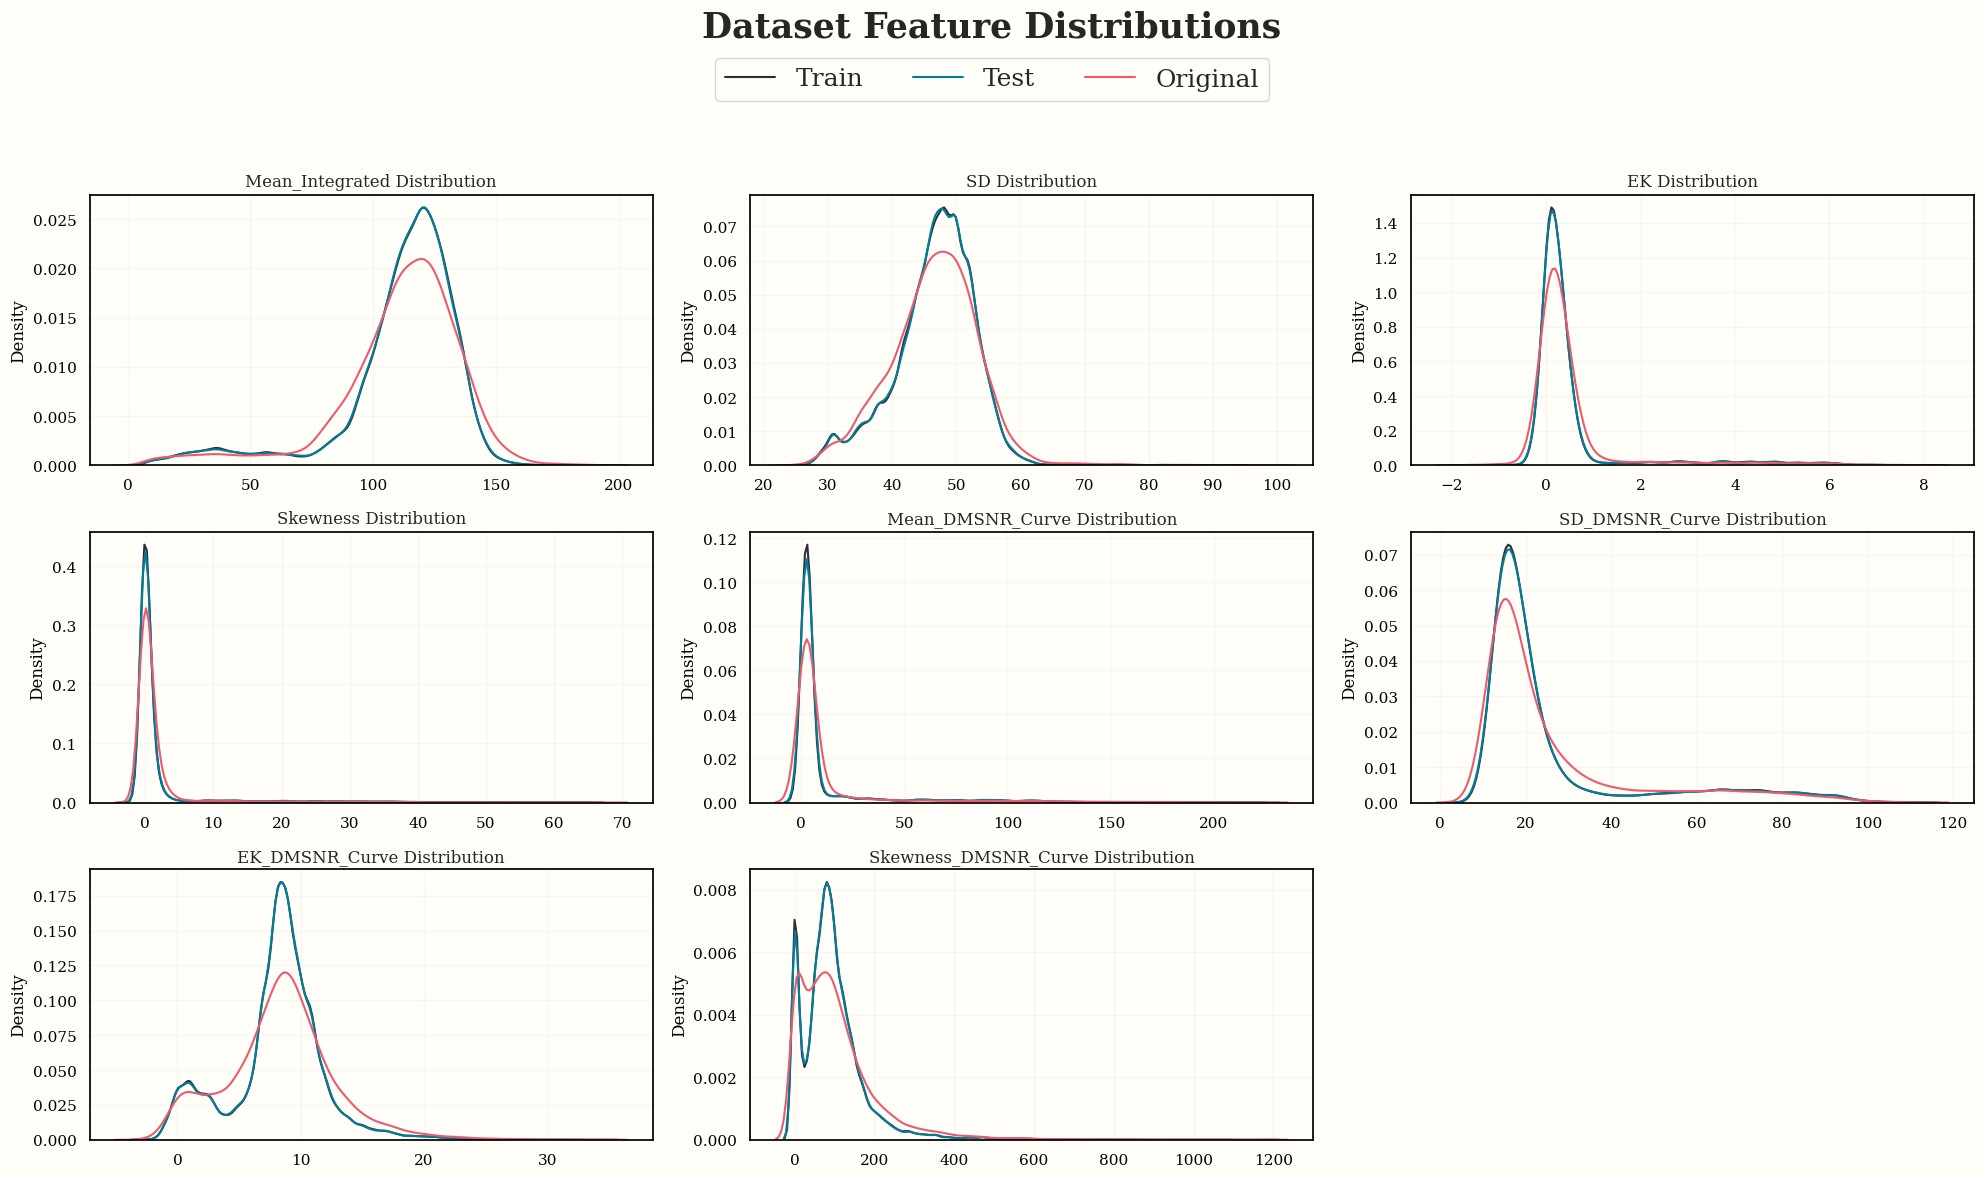

In [5]:
# kudos to @jcaliz for the visualization 
features = test_df.columns
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train_df[column], label='Train',
        ax=ax[i], color=palette[0]
    )
    
    sns.kdeplot(
        test_df[column], label='Test',
        ax=ax[i], color=palette[1]
    )
    
    sns.kdeplot(
        original_df[column], label='Original',
        ax=ax[i], color=palette[-4]
    )
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), fontsize=18, ncol=3)
plt.tight_layout()

In [6]:
print('Classes balance')

print('Synthetic')
display(target.value_counts(True))

print('\nOriginal')
display(original_target.value_counts(True))

Classes balance
Synthetic


0    0.906715
1    0.093285
Name: Class, dtype: float64


Original


0    0.908426
1    0.091574
Name: Class, dtype: float64

<div class='alert alert-block alert-success'><b>Insights</b>
    
Some sharpening of the original dataset has been done to create the syntethic data.

In some cases it affected the simmetry of the distribution: SD_DMSNR_Curve, EK_DMSNE_Curve

In [7]:
print('Duplicates on Synthetic Train: ', train_df.duplicated().sum())
print('Duplicates on Synthetic Test:  ', test_df.duplicated().sum())
print('Duplicates on Original:        ', original_df.duplicated().sum())

Duplicates on Synthetic Train:  0
Duplicates on Synthetic Test:   0
Duplicates on Original:         0


#### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Numeric features distributions w/r to classes</p>

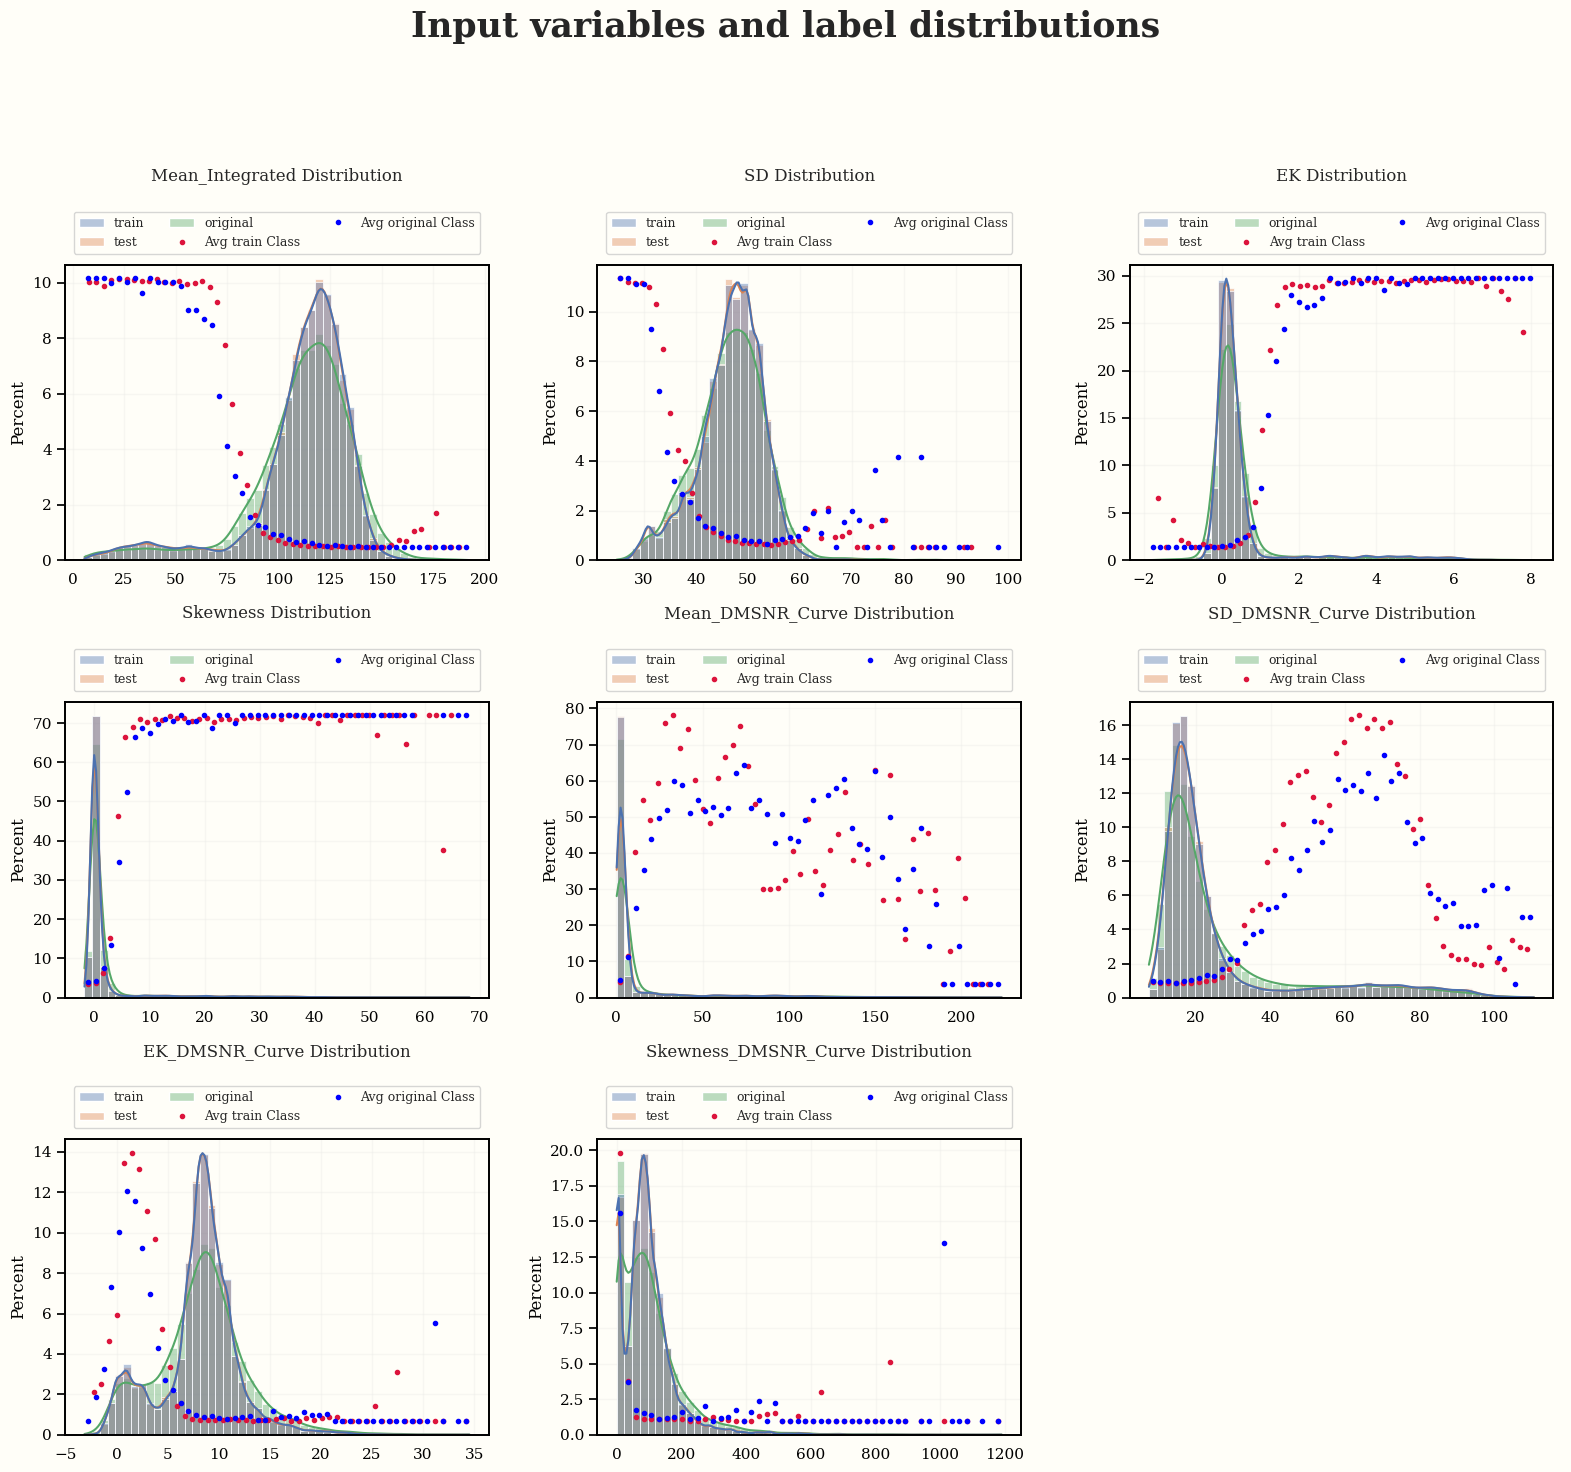

In [8]:
def plot_continous(feature, ax):
    temp = total_df.copy()
#     temp[feature] = temp[feature].clip(upper=temp[feature].quantile(0.99))
    
    sns.histplot(data=temp, x=feature,
                hue='set',ax=ax, hue_order=hue_labels,
                common_norm=False, **histplot_hyperparams)
    
    ax_2 = ax.twinx()
    ax_2 = plot_dot_continous(
        total_df.query('set=="train"'),
        feature, target, ax_2,
        color='crimson', df_set='train'
    )
    
    ax_2 = plot_dot_continous(
        total_df.query('set=="original"'),
        feature, original_target, ax_2,
        color='blue', df_set='original'
    )
    
    return ax_2
        
    
def plot_dot_continous(
    df, column, target, ax_2,
    show_yticks=False, color=str,
    df_set='train'
):

    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = target.groupby(bins).mean()
    ax_2.plot(
        target.index,
        target, linestyle='',
        marker='.', color=color,
        label=f'Avg {df_set} {target.name}'
    )
    ax_2.grid(visible=False)
    
    if not show_yticks:
        ax_2.get_yaxis().set_ticks([])
    
    return ax_2


total_df = pd.concat([
    train_df.assign(set='train'),
    test_df.assign(set='test'),
    original_df.assign(set='original'),
], ignore_index=True)

total_df.reset_index(drop=True, inplace=True)
hue_labels = ['train', 'test', 'original']

numeric_features = [
    'Mean_Integrated', 'SD', 'EK', 'Skewness',
    'Mean_DMSNR_Curve', 'SD_DMSNR_Curve',
    'EK_DMSNR_Curve', 'Skewness_DMSNR_Curve'
]

n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}
line_style='--'

columns =  numeric_features
n_cols = 3
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
ax = ax.flatten()

for i, column in enumerate(columns):
    ax2 = plot_continous(column, ax[i])
    # titles
    ax[i].set_title(f'{column} Distribution', pad=60);
    ax[i].set_xlabel(None)

    handles, labels = [], []
    plot_axes = [ax[i]]
    
#     Set legend for each plot
    for plot_ax in [ax[i], ax2]:
        if plot_ax.get_legend() is not None:
            handles += plot_ax.get_legend().legendHandles
            labels += [x.get_text() for x in plot_ax.get_legend().get_texts()]
        else:
            handles += plot_ax.get_legend_handles_labels()[0]
            labels += plot_ax.get_legend_handles_labels()[1]
            
    ax[i].legend(
        handles, labels,
        fontsize=9,
        bbox_to_anchor=(0.5, 1.2), ncol=3,
        loc='upper center'
    )

for i in range(i+1, len(ax)):
    ax[i].axis('off') 
fig.suptitle(f'Input variables and label distributions \n\n\n', ha='center',  fontweight='bold', fontsize=25)
plt.tight_layout()

<div class='alert alert-block alert-success'><b>Insights</b>
    
The average class distribution per bin w/r to input variables distribution show little to no differences between train and original datasets.

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Numerical features correlations</p>

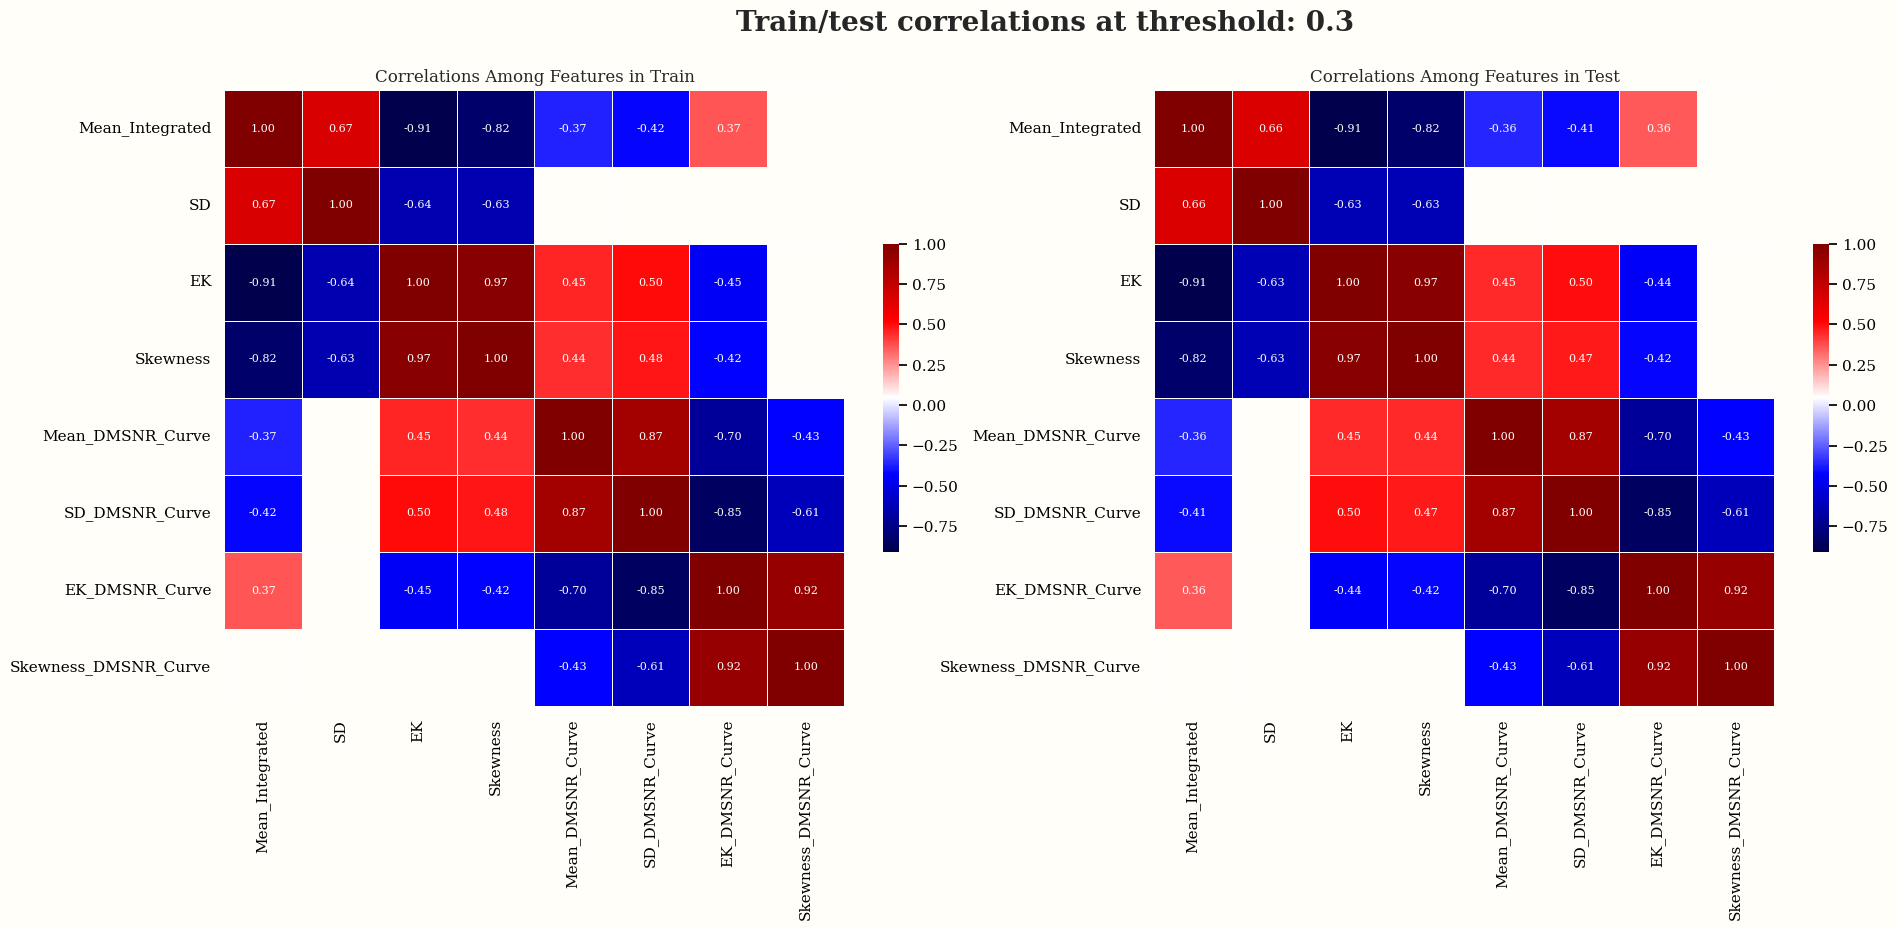

In [9]:
## Explore the correlation between all numerical features
corr_mat_train = train_df.drop(columns = ['Class'], axis = 1).corr()
corr_mat_test = test_df.corr()
delta_corr_train= corr_mat_train -corr_mat_test

## Keep only correlation higher than a threshold
threshold = 0.3
corr_threshold_train = corr_mat_train[(corr_mat_train > threshold) | (corr_mat_train < -threshold)]
corr_threshold_test = corr_mat_test[(corr_mat_test > threshold) | (corr_mat_test < -threshold)]


fig, axes = plt.subplots(1, 2, figsize = (22, 8))
sns.heatmap(corr_threshold_train, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features in Train')
sns.heatmap(corr_threshold_test, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features in Test');
fig.suptitle(f'Train/test correlations at threshold: 0.3 \n\n\n', ha='center',  fontweight='bold', fontsize=20)
plt.show()


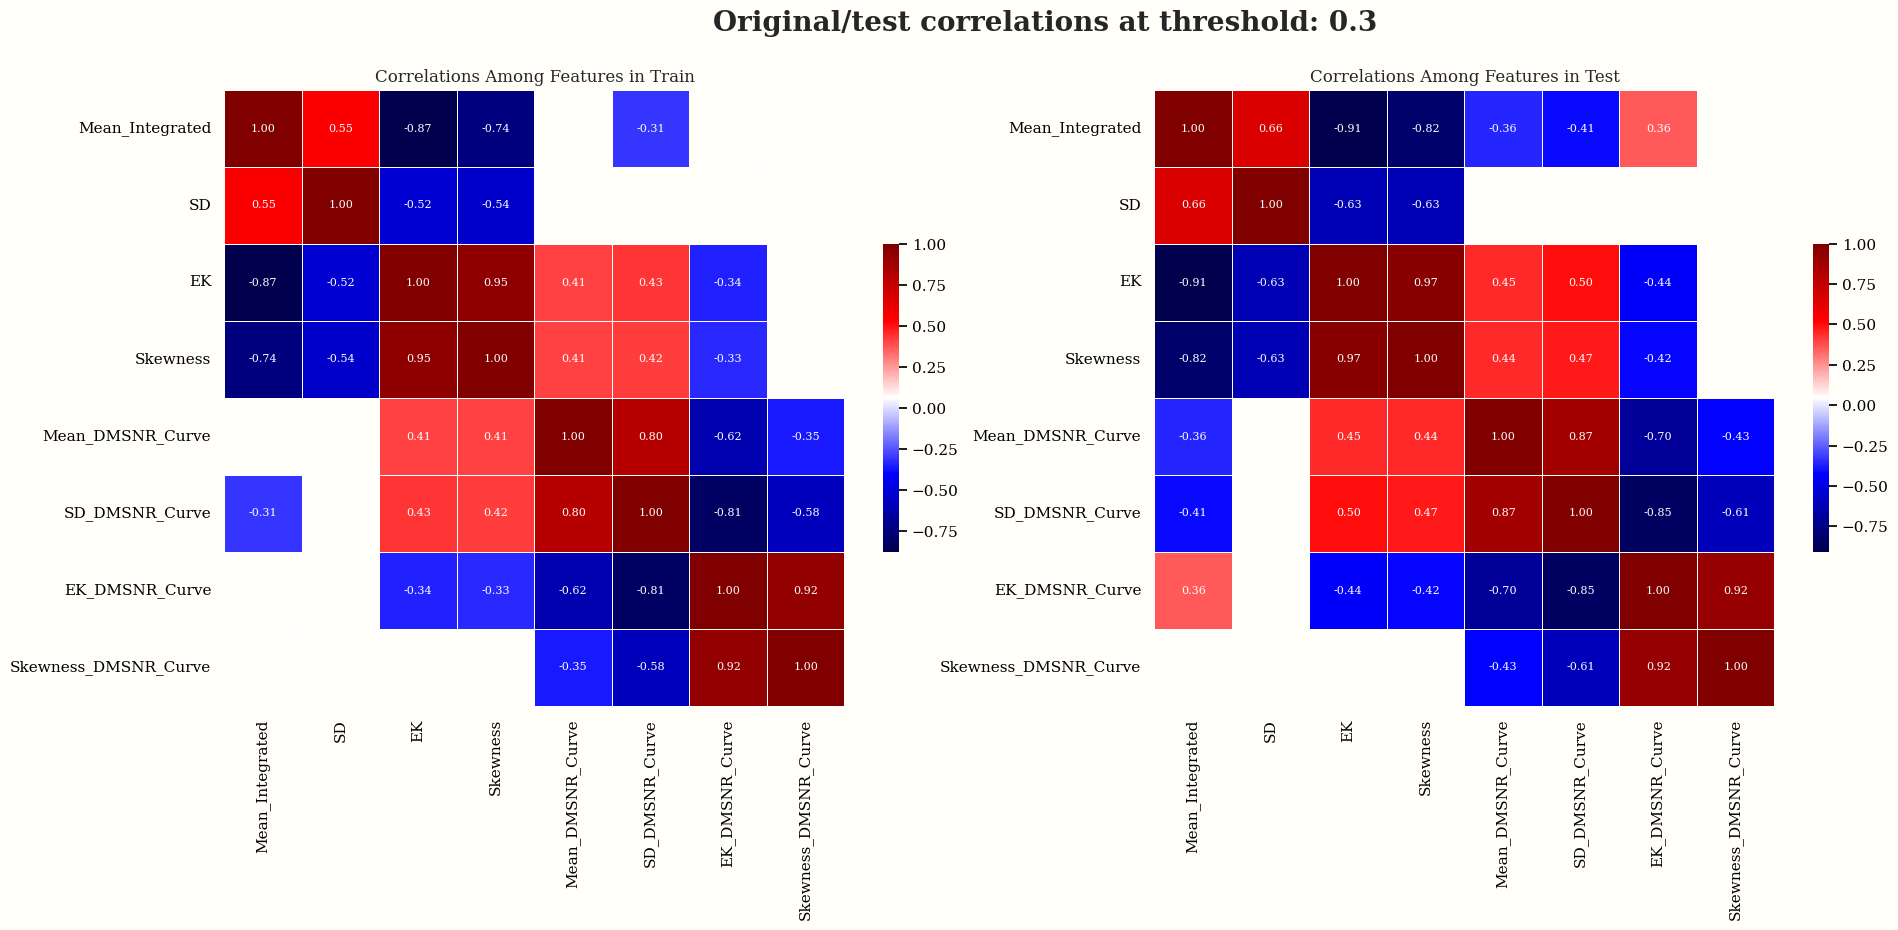

In [10]:
## Explore the correlation between all numerical features
corr_mat_original = original_df.drop(columns = ['Class'], axis = 1).corr()
corr_mat_test = test_df.corr()
delta_corr_original= corr_mat_original - corr_mat_test

## Keep only correlation higher than a threshold
threshold = 0.3
corr_threshold_original = corr_mat_original[(corr_mat_original > threshold) | (corr_mat_original < -threshold)]
corr_threshold_test = corr_mat_test[(corr_mat_test > threshold) | (corr_mat_test < -threshold)]


fig, axes = plt.subplots(1, 2, figsize = (22, 8))
sns.heatmap(corr_threshold_original, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Correlations Among Features in Train')
sns.heatmap(corr_threshold_test, annot = True, cmap = 'seismic', fmt = ".2f",
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Correlations Among Features in Test');
fig.suptitle(f'Original/test correlations at threshold: 0.3 \n\n\n', ha='center',  fontweight='bold', fontsize=20)
plt.show()



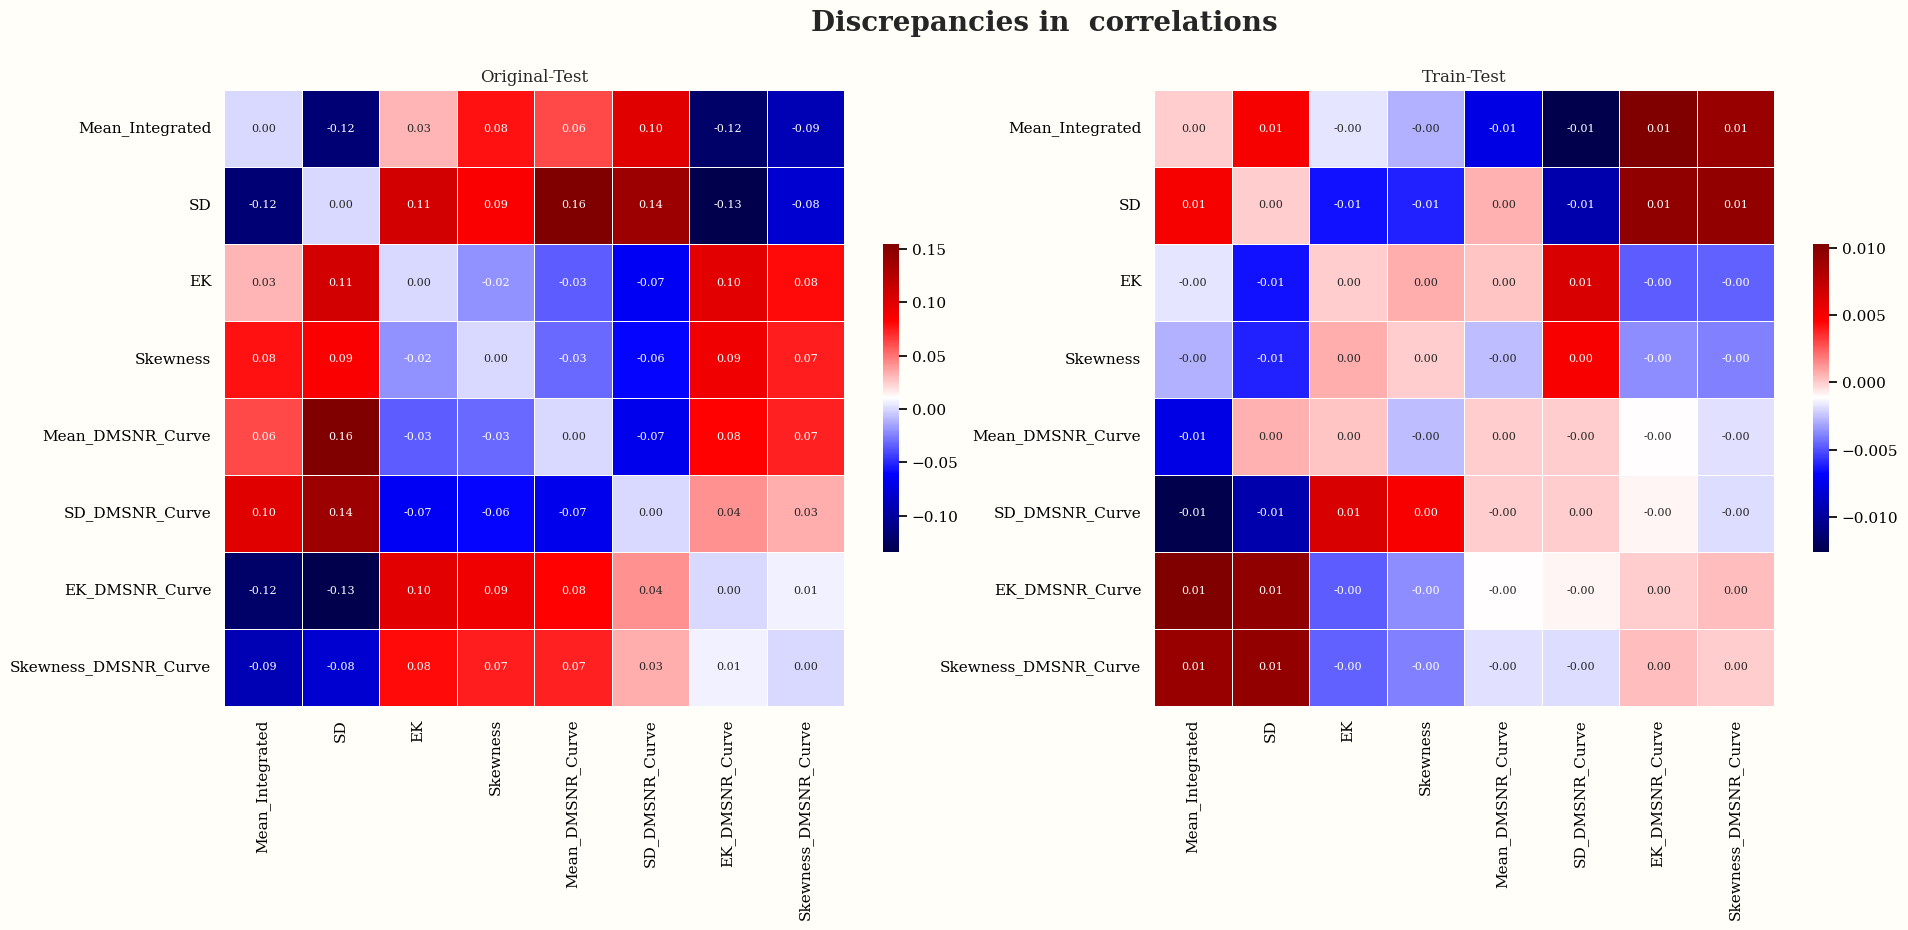

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (22, 8))
sns.heatmap(delta_corr_original, annot = True, fmt = ".2f", cmap = 'seismic',
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[0]).set_title('Original-Test');
sns.heatmap(delta_corr_train, annot = True, fmt = ".2f", cmap = 'seismic',
            linewidths = 0.5, cbar_kws={'shrink': .5},annot_kws={'size': 8}, ax = axes[1]).set_title('Train-Test');
fig.suptitle(f'Discrepancies in  correlations \n\n\n', ha='center',  fontweight='bold', fontsize=20)
plt.show()

<Figure size 1800x2000 with 0 Axes>

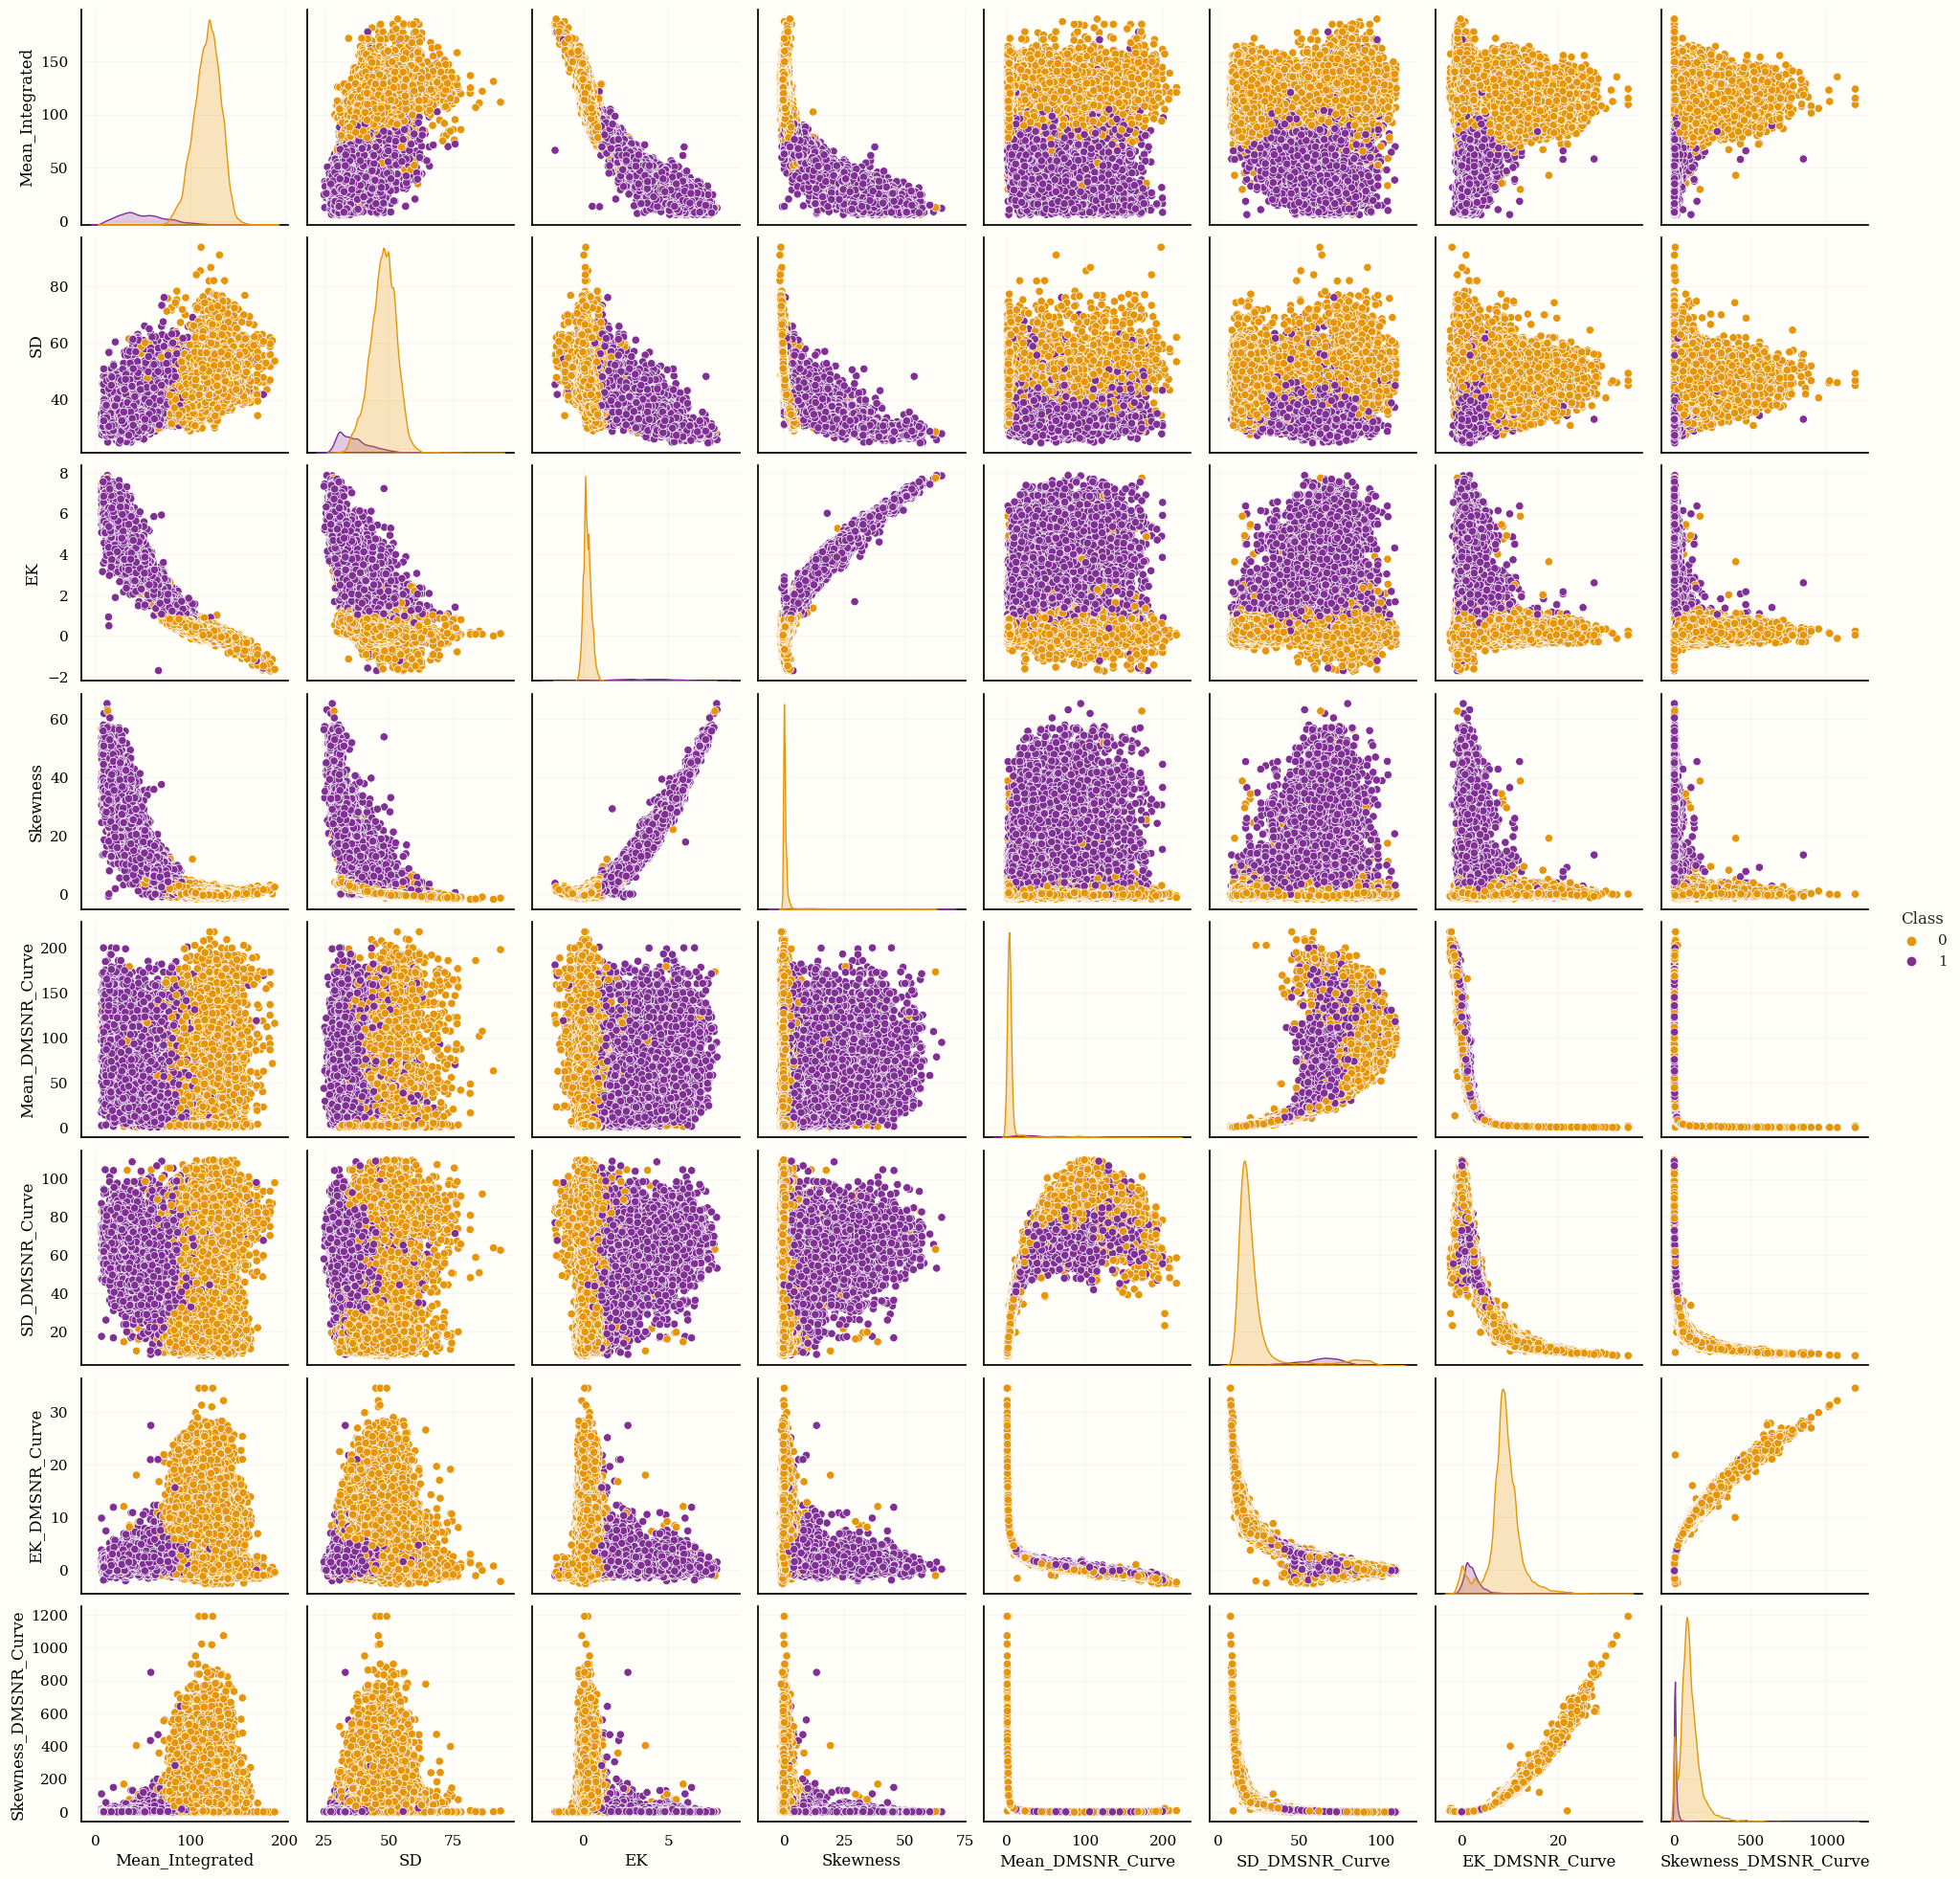

In [12]:
plt.figure(figsize = (18, 20))
sns.pairplot(train_df.reset_index(drop=True), 
             hue='Class', 
             palette='CMRmap_r')
fig.suptitle(f'Train set pairplot \n\n\n', ha='center',  fontweight='bold', fontsize=20)
plt.show()

<Figure size 1800x2000 with 0 Axes>

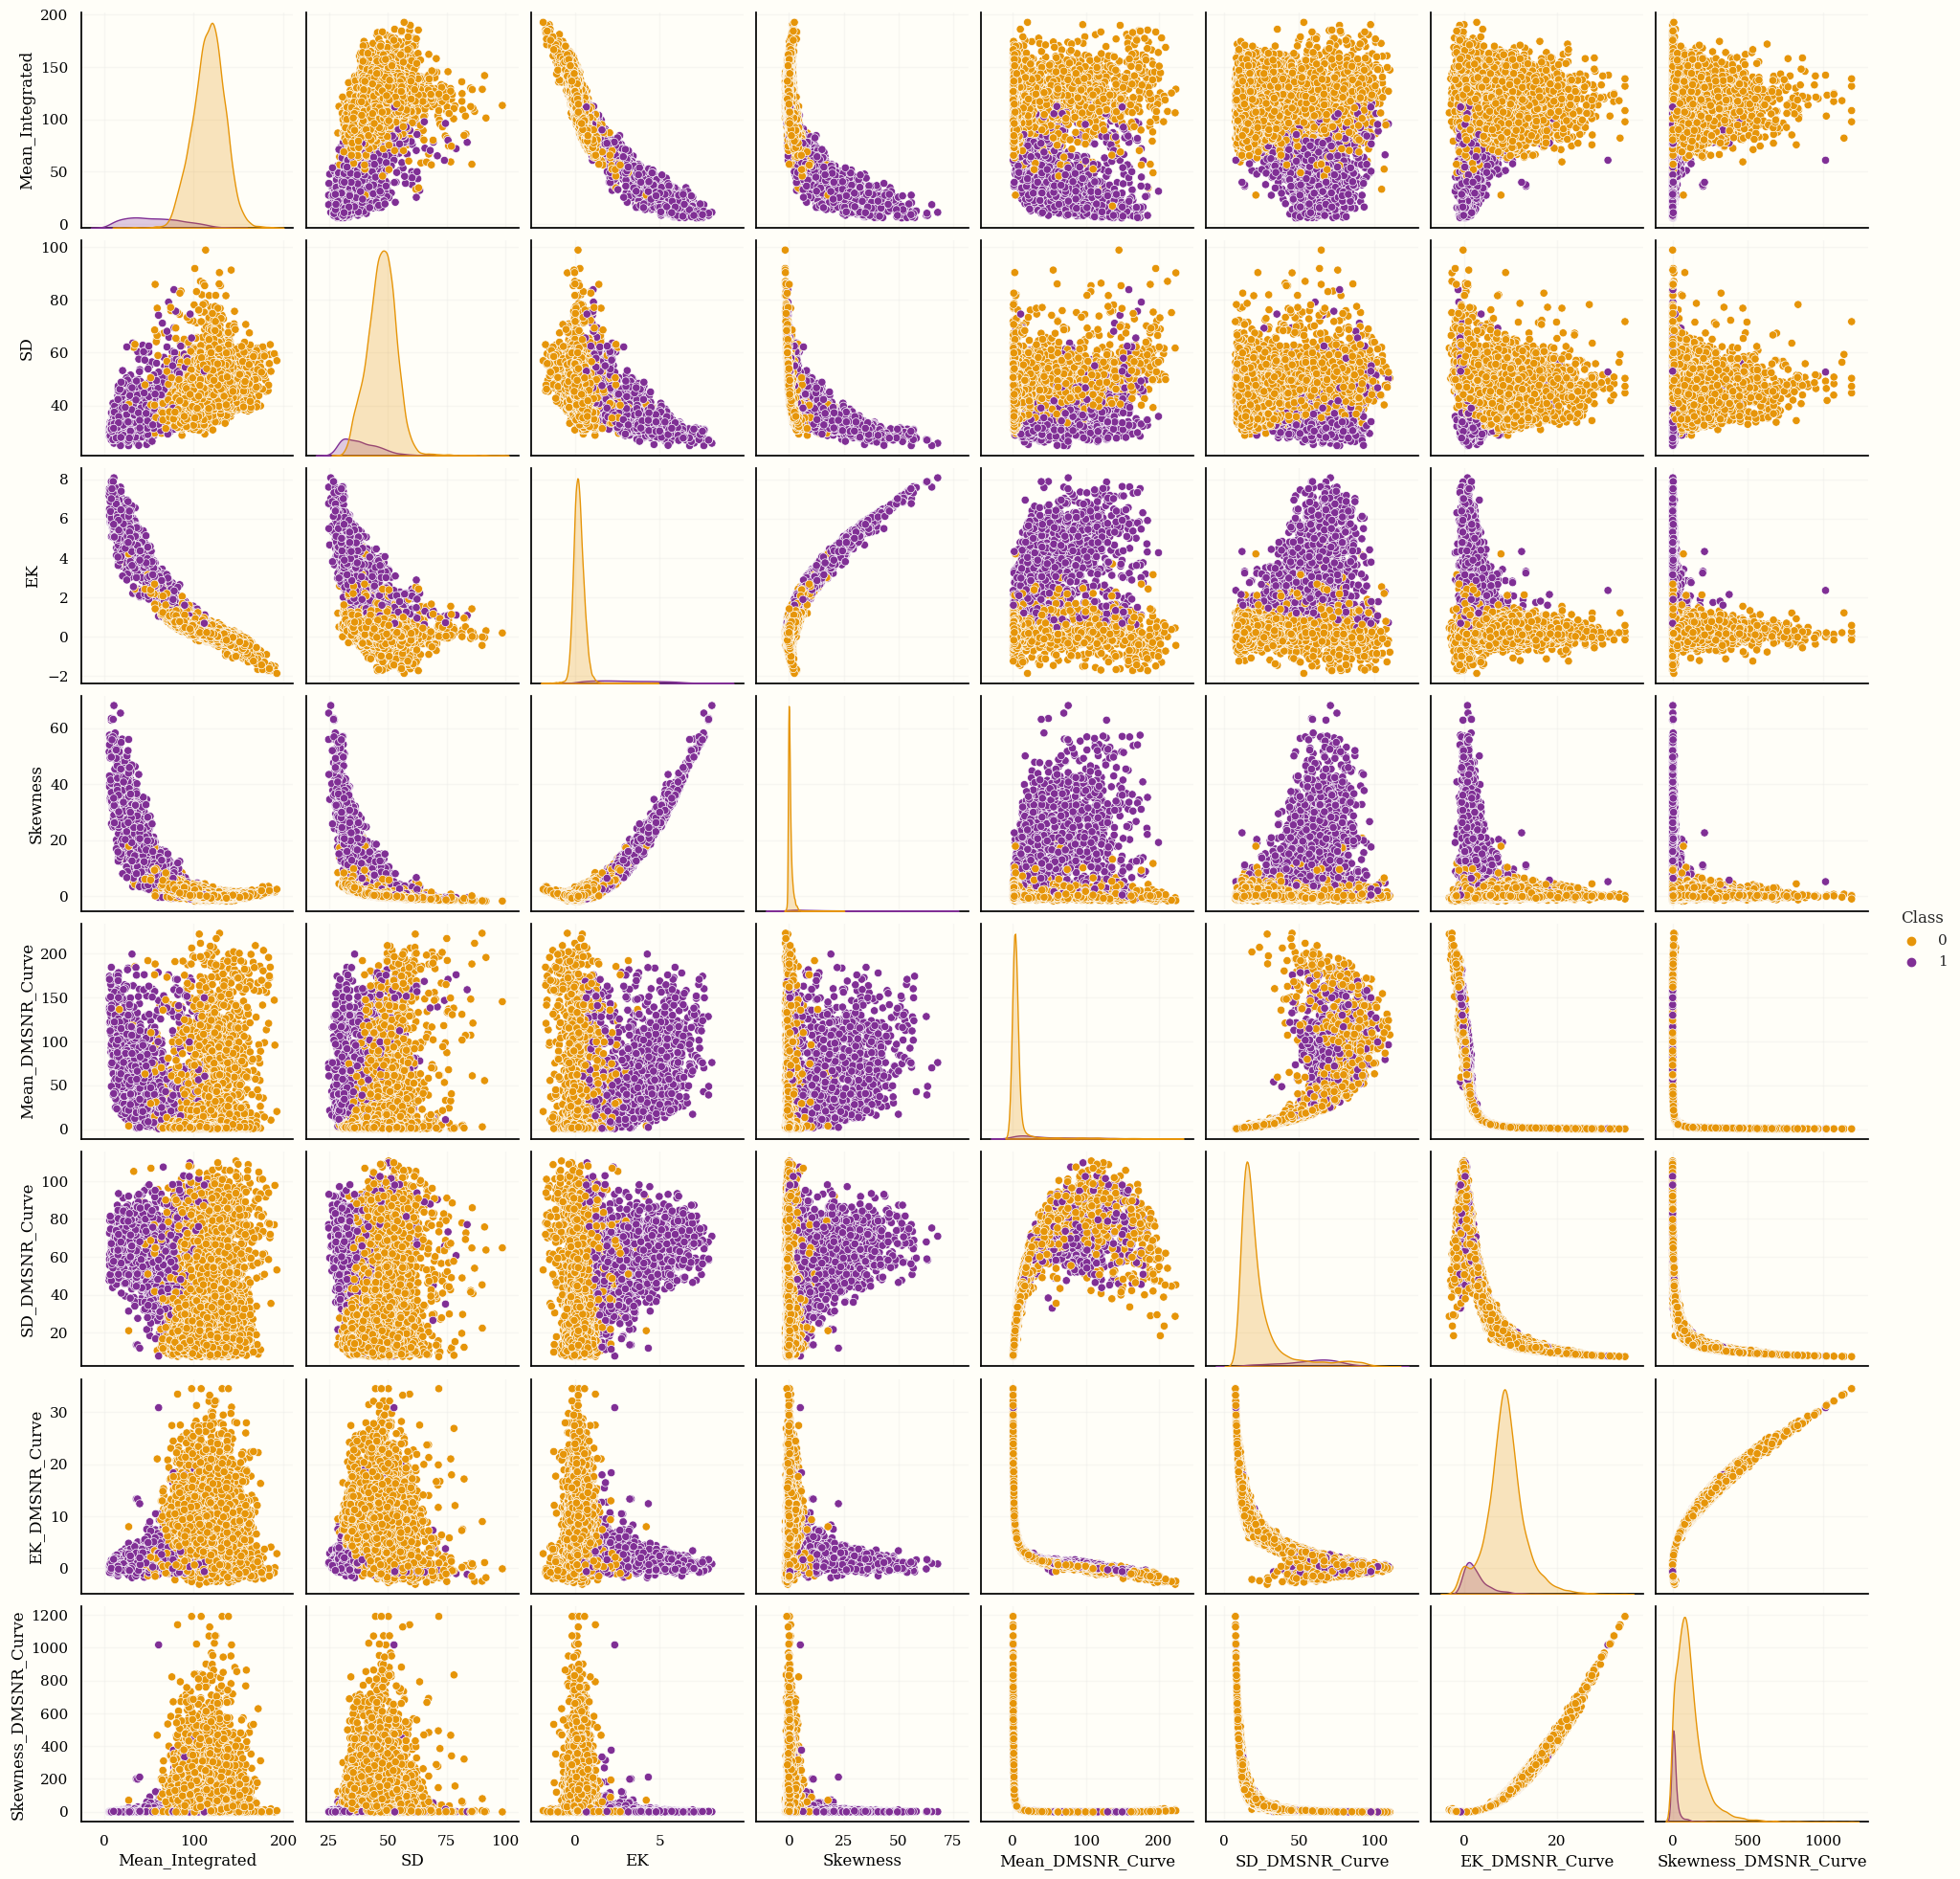

In [13]:
plt.figure(figsize = (18, 20))
sns.pairplot(original_df.reset_index(drop=True), hue='Class', palette='CMRmap_r')
fig.suptitle(f'Original set pairplot \n\n\n', ha='center',  fontweight='bold', fontsize=20)
plt.show()

<div class='alert alert-block alert-success'><b>Insights</b>
    
Some features seems to allow a decent classes separation, the majority are pretty noisy.


In [14]:
#https://feature-engine.trainindata.com/en/latest/user_guide/selection/DropCorrelatedFeatures.html

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Adversarial validation</p>

#### I'm gonna train a catboost classifier to understand how and if the orginal and the train dfs are distinguishable

In [15]:
original_df['dataset_label'] = 'original'
train_df['dataset_label'] = 'train'
aux_target = 'dataset_label'

In [16]:
def create_adversarial_data(df_1, df_2, cols, N_val=50000):
    df_master = pd.concat([df_1[cols], df_2[cols]], axis=0)
    adversarial_val = df_master.sample(N_val, replace=False)
    adversarial_train = df_master[~df_master.index.isin(adversarial_val.index)]
    return adversarial_train, adversarial_val

features = list(train_df.drop(['dataset_label'], axis=1).columns)
all_cols = features + [aux_target]
adversarial_train, adversarial_test = create_adversarial_data(original_df, train_df, all_cols)

In [17]:
train_data = Pool(
    data=adversarial_train[features],
    label=adversarial_train[aux_target]
)

holdout_data = Pool(
    data=adversarial_test[features],
    label=adversarial_test[aux_target]    
)

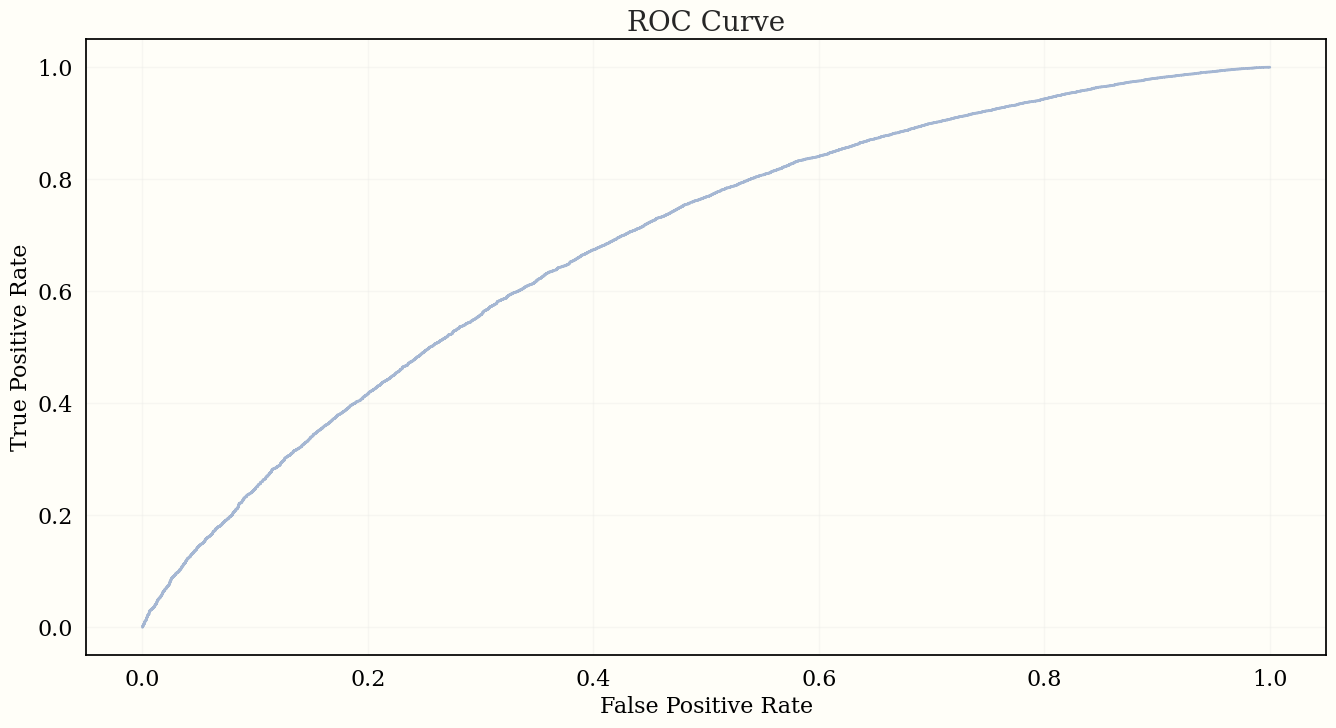

In [18]:
params = {
    'iterations': 100,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'od_wait': 50,
}

model = CatBoostClassifier(**params)
_ = model.fit(train_data, eval_set=holdout_data, verbose=0)

# Receiver Operator Characteristic Curve
_ = get_roc_curve(model, 
                  holdout_data,
                  thread_count=-1,
                  plot=True)

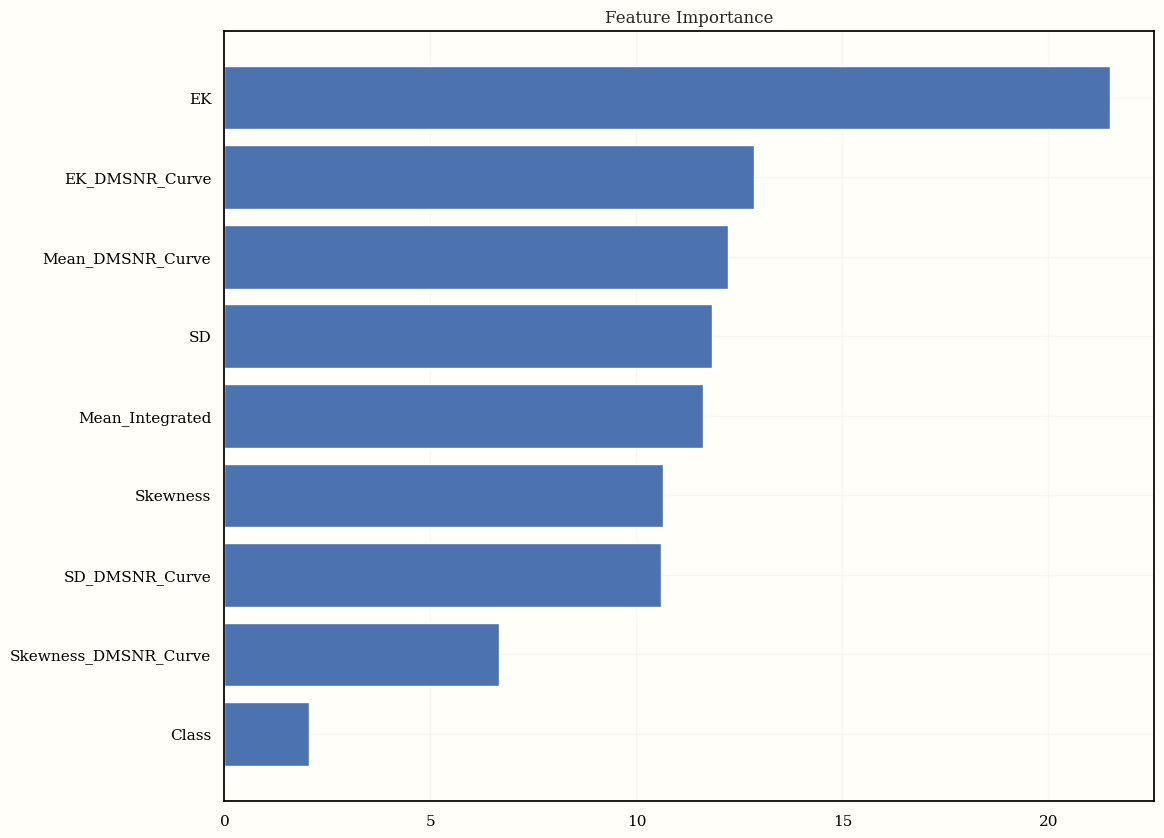

In [19]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(original_df.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

<div class='alert alert-block alert-success'><b>Insights</b>
    
Excess of Kurtosis and Mean of the integrated profile are the main responsibles for the discriminability of the two datasets.


### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Manifold representation </p>


#### Legend: -1 correspond to train dataset, 1 to original

In [20]:
import umap.umap_ as umap
import umap.plot

In [21]:
full_df = pd.concat([original_df, train_df])
# Making the representation slightly lighter
aux_df=full_df.iloc[::10, :]

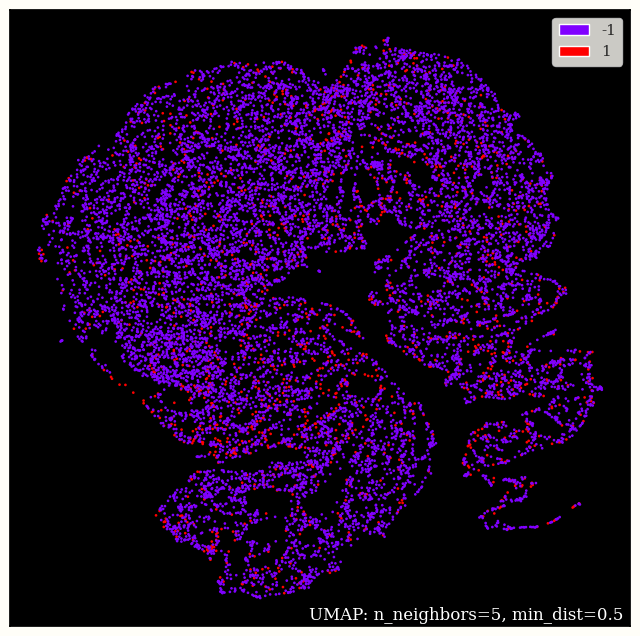

In [22]:
mapper = umap.UMAP(n_neighbors=5, min_dist=0.5).fit(aux_df.drop('dataset_label', axis=1).values)
codes = {'original':1, 'train':-1}
umap.plot.points(mapper, aux_df['dataset_label'].map(codes), background='black', theme='fire')
plt.show()

Some density concretion? Maybe!

<div class='alert alert-block alert-success'><b>Further developement</b>

Some **SMOTE** to address the imbalanced labels distro? https://www.sciencedirect.com/science/article/abs/pii/S2213133720300585
    
State of the art paragraph interesting: https://arxiv.org/pdf/2005.01208.pdf

#### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Outliers detection</p>


In [23]:
# Thanks to Dmitry Uarov for the topic: https://www.kaggle.com/competitions/playground-series-s3e10/discussion/393093
# Same result can be achieved using Mahalanobis distance

outliers_train = train_df[
    (train_df['Class']==1)&
    (train_df['Mean_Integrated']>115)&
    (train_df['SD']>45)&
    (train_df['EK']<0.03)&
    (train_df['Skewness']<1)&
    (train_df['Mean_DMSNR_Curve']<20)
].index

outliers_orig = original_df[
    (original_df['Class']==1)&
    (original_df['Mean_Integrated']>115)&
    (original_df['SD']>45)&
    (original_df['EK']<0.03)&
    (original_df['Skewness']<1)&
    (original_df['Mean_DMSNR_Curve']<20)
].index

In [24]:
train_df.iloc[outliers_train]

Mean_Integrated         SD        EK  Skewness  Mean_DMSNR_Curve  \
15488        153.179688  50.171079 -0.296733 -0.305434         10.086120   
74299        139.171875  63.300197 -0.322330 -0.972711          7.868729   
76395        138.039062  57.427789 -0.079245 -0.900060          8.346990   
111145       138.070312  49.816765 -0.227630 -0.067414         13.367893   

        SD_DMSNR_Curve  EK_DMSNR_Curve  Skewness_DMSNR_Curve  Class  \
15488        36.851554        3.992891             14.644572      1   
74299        34.692251        4.794206             22.498284      1   
76395        34.061516        4.740411             23.342690      1   
111145       44.425855        3.529511             11.675515      1   

       dataset_label  
15488          train  
74299          train  
76395          train  
111145         train

In [25]:
train_df=train_df.drop(outliers_train)

In [26]:
original_df.iloc[outliers_orig]

Mean_Integrated         SD        EK  Skewness  Mean_DMSNR_Curve  \
4790       137.929688  52.980271 -0.094888  0.131425          2.370401   
5142       127.570312  52.577426 -0.027292 -0.395729          3.480769   

      SD_DMSNR_Curve  EK_DMSNR_Curve  Skewness_DMSNR_Curve  Class  \
4790       18.103218        9.198939             94.393676      1   
5142       24.750470        7.434578             56.247469      1   

     dataset_label  
4790      original  
5142      original

In [27]:
original_df=original_df.drop(outliers_orig)

In [28]:
full_df = pd.concat([original_df, train_df])

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Features eng</p>

#### As suggested in these topic, and not because i'm lazy, i'm not gonna combine existing features (roughly) because them are already derivative.

- https://www.kaggle.com/competitions/playground-series-s3e10/discussion/393036
- https://www.kaggle.com/competitions/playground-series-s3e10/discussion/393328

### <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#9E3F00; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #9E3F00">Modeling</p>
